# 1. Import and Install Dependencies

In [44]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [45]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [46]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [47]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [48]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          ) 
    # # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# 3. Extract Keypoint Values

In [49]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

# 6. Preprocess Data and Create Labels and Features

In [50]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [51]:
actions = os.listdir('./MP_Data')
actions = np.array(actions)

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('./MP_Data') 

# Thirty videos worth of data
no_sequences = 80

# Videos are going to be 30 frames in length
sequence_length = 24

In [52]:
label_map = {label:num for num, label in enumerate(actions)}

In [53]:
label_map

{'hello': 0,
 'how much': 1,
 'thank you': 2,
 'name': 3,
 'cost': 4,
 'your': 5,
 'hungry': 6,
 'phone': 7,
 'beautiful': 8,
 'good job': 9,
 'sad': 10,
 'what': 11,
 'father': 12,
 'i love you': 13}

In [54]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [55]:
X = np.array(sequences)
X.shape

(1120, 24, 258)

In [56]:
y = to_categorical(labels).astype(int)
y.shape

(1120, 14)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1008, 24, 258), (112, 24, 258), (1008, 14), (112, 14))

# 7. Build and Train LSTM Neural Network

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
import tensorflow as tf

In [59]:
log_dir = os.path.join('Logs')
tb_callback = [
    # TensorBoard(log_dir=log_dir),
    ReduceLROnPlateau(factor=0.1, patience=5)
]

In [60]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(24,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 24, 64)            82688     
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 128)           98816     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 14)               

In [62]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                        epochs=50, 
                        callbacks=[tb_callback],
                        validation_data = (X_test, y_test))

Epoch 1/50
32/32 [==============================] - 10s 158ms/step - loss: 2.6149 - accuracy: 0.0645 - val_loss: 2.5266 - val_accuracy: 0.0536
Epoch 2/50
32/32 [==============================] - 4s 130ms/step - loss: 2.4562 - accuracy: 0.1250 - val_loss: 2.2921 - val_accuracy: 0.2143
Epoch 3/50
32/32 [==============================] - 4s 126ms/step - loss: 2.2235 - accuracy: 0.2321 - val_loss: 1.9267 - val_accuracy: 0.2679
Epoch 4/50
32/32 [==============================] - 5s 165ms/step - loss: 1.9508 - accuracy: 0.2798 - val_loss: 1.6546 - val_accuracy: 0.4643
Epoch 5/50
32/32 [==============================] - 4s 118ms/step - loss: 1.7467 - accuracy: 0.3750 - val_loss: 1.5322 - val_accuracy: 0.5268
Epoch 6/50
32/32 [==============================] - 4s 125ms/step - loss: 1.5273 - accuracy: 0.4405 - val_loss: 1.2296 - val_accuracy: 0.6071
Epoch 7/50
32/32 [==============================] - 4s 121ms/step - loss: 1.3437 - accuracy: 0.5278 - val_loss: 0.9688 - val_accuracy: 0.7321
Epoch

Text(0.5, 1.0, 'Training and Validation Loss')

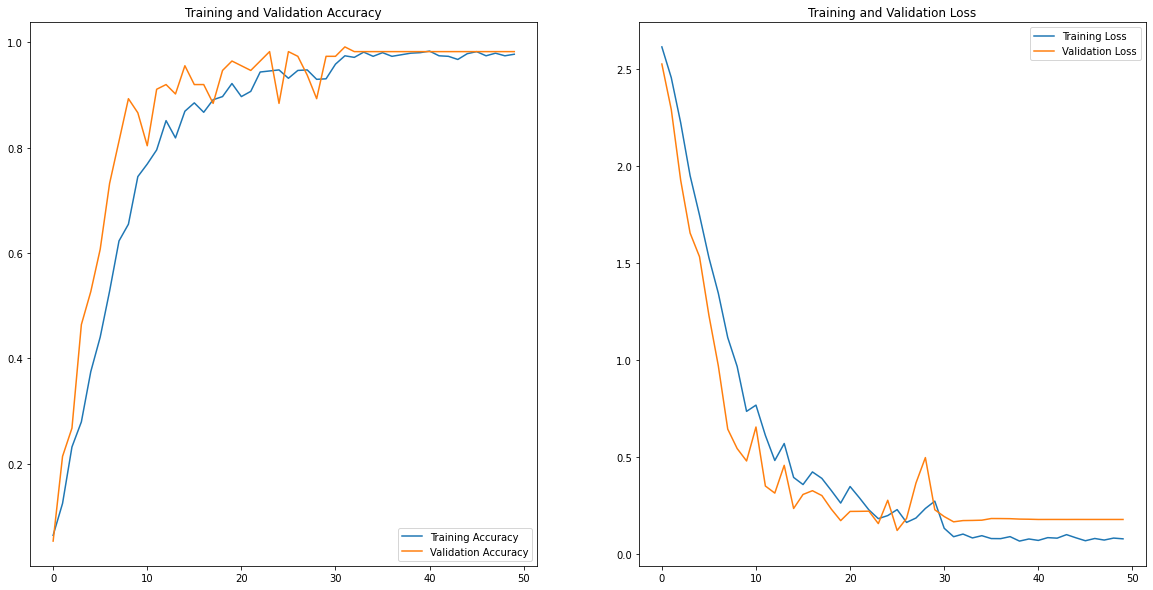

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = history.epoch

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# 8. Make Predictions

In [40]:
res = model.predict(X_test)

In [41]:
actions[np.argmax(res[11])]

'good job'

In [42]:
actions[np.argmax(y_test[11])]

'good job'

# 9. Save Weights

In [65]:
model.save('model_13classes_261021.h5')